#install pytorch & import

In [1]:
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

In [2]:
!pip install --upgrade torch torchvision

  Using cached https://files.pythonhosted.org/packages/49/0e/e382bcf1a6ae8225f50b99cc26effa2d4cc6d66975ccf3fa9590efcbedce/torch-0.4.1-cp36-cp36m-manylinux1_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x59ed4000 @  0x7f6d3d8972a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [3]:
#version check
from math import sqrt
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as splinalg

from time import time
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader,TensorDataset
torch.__version__

'0.4.1'

#LISTA  &  helper function for making LISTA

In [0]:
class myLISTA(torch.nn.Module):
    def __init__(self, num_unroll, A, l=1., scale=1., prox=None):
        super(myLISTA, self).__init__()
        self.num_unroll = num_unroll
        self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True) # lambda
        self.scale = scale
        self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=False)
    
        # h: soft shrink function h_theta(x)
        if prox is None:
            self.prox = lambda z, th: torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.FloatTensor([0]))
        else:
            self.prox = prox
        
    def forward(self, b):
        theta = torch.mul(self.l, self.scale)
        # prox(A.dot(b*scale), theta) for initial guess of x
        x = self.prox(torch.matmul(torch.t(self.A), torch.mul(b, self.scale)), theta)
        for i in range(self.num_unroll):
            # x = prox(x+A.T.dot(b-A.dot(x))*scale, theta)
            x = self.prox(x + torch.mul(torch.matmul(torch.t(self.A), b - torch.matmul(self.A, x)), self.scale), theta)
        return x

In [5]:
tensor1 = torch.randn(3, 4)
tensor2 = torch.randn(4)
print(tensor2)
tensor2 += tensor2
print(tensor2)


tensor([ 0.4969, -0.6736,  0.3962, -1.4275])
tensor([ 0.9938, -1.3472,  0.7925, -2.8550])


#Prepare Datasets

In [6]:
n_samples = 100
batch_size = 1
#Generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 512, 2048
m, n = 256,512 
#m, n = 2000, 4000
x_trains = np.random.randn(n_samples, m)
y_labels = np.random.randn(n_samples, n)
# use a random matrix as a basis (design matrix)
A = rng.randn(m, n) / np.sqrt(m*2)

# generate a k-sparse Gaussian signal vector
k = 50
stdx = 1.
snr = 10.

weight = torch.from_numpy(A).float()

for i in range(n_samples) :
  
    x_true = np.zeros(n,dtype=np.float32)
    T = np.sort(rng.choice(k*2,k,replace=False))
    #print('True support of %d nonzeros = ' % (k))
    #print(T)
    x_true[T] = rng.randn(k) * stdx

    # make the query vector
    b = A.dot(x_true)


    # add noise

    normb = linalg.norm(b)
    noise = rng.randn(m)
    noise = noise / linalg.norm(noise) * normb / snr
    tol = linalg.norm(noise)
    b = b + noise
  
    x_trains[i, :] = b
    y_labels[i, :] = x_true

x_data = torch.from_numpy(x_trains).float()
y_data = torch.from_numpy(y_labels).float()
print(x_data.size())
print(y_data.size())
train_set = TensorDataset(x_data,y_data)
data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#print(x_data[0])

torch.Size([100, 256])
torch.Size([100, 512])


In [0]:
# soft thresholding function
def soft(z, th):
    return np.sign(z) * np.maximum(np.abs(z) - th, 0)

from scipy import linalg
# Iterative soft thresholding (IST)
def IST(A, b, tol=1e-5, maxiter=300, l=1., L=None):
    m, n = A.shape
    x = np.zeros(n)
    r = b.copy()
    if L is None:    # roughly estimate the Lipschitz constant
        L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
    count = 0
    cost_history = []
    normr = linalg.norm(r)
    while count < maxiter and normr > tol:
        count += 1
        x = soft(x + A.T.dot(r) / L, l/L)
        r = b - A.dot(x)
        normr = linalg.norm(r)
        cost_history.append( normr*normr + l*np.sum(np.abs(x)) )
    return x, cost_history


2.5462663499099527


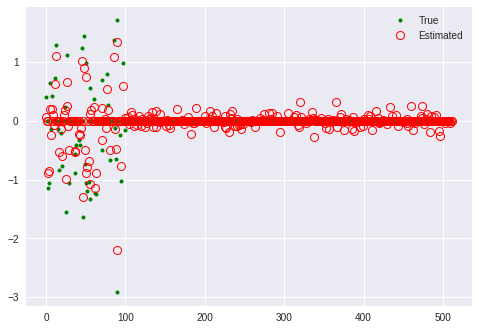

In [8]:
l = 0.1*(stdx*stdx / k * m) / np.sqrt(snr) / normb
L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
maxit = 50
x_est = IST(A,b,maxiter=maxit,l=l,L=L)[0]
print(np.linalg.norm(x_true-x_est))
import matplotlib.pyplot as plt
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper right', shadow=False)
plt.show()

In [0]:
#soft shrinkage function with learnable lambda
def softshrink(z,th):
    return torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.FloatTensor([0]))

In [10]:
#Define NN hyper parameters and  model
input_size, output_size, n_layers  = m, n, 0
l = 0.1*(stdx*stdx / k * m) / np.sqrt(snr) / normb
#l = 0.0001
L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
model = myLISTA(n_layers, A, l=l, scale=1./L, prox=lambda z,th: softshrink(z,th))

print(model)
#print(model.state_dict())

myLISTA()


4.784855
2.5462663499099527


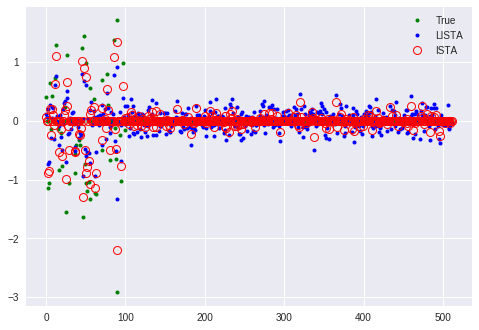

In [11]:
#print(b.shape)
#print(torch.from_numpy(b).float().size())
#print(x_est)
with torch.no_grad():
    b_torch=  torch.from_numpy(b).float()
    output_init = model(b_torch)
#print(output_init)
print(np.linalg.norm(output_init.detach().cpu().numpy()-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n),output_init.detach().cpu().numpy(), 'b.', markersize=8, mec='green', label='LISTA')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='ISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

#Loss & Optimizer

In [0]:
#Define Loss and Optimizer
learning_rate = 0.03
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
#training
num_epochs = 10
display_step = 1
running_loss = 0.0

for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for x_train, y_train in data_loader:
        x_train = torch.transpose(x_train, 0, 1)
        y_train = torch.transpose(y_train, 0, 1)
        #print(x_train.size())
        #print(y_train.size())
        # Forward pass
      
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
    
        # Backward and optimize
        optimizer.zero_grad() 
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
    if (epoch+1) % display_step == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))
        print('Lambda: [{}]'.format(model.l))

Epoch [1/10], Loss: 1.0727
Lambda: [Parameter containing:
tensor([0.0854], requires_grad=True)]
Epoch [2/10], Loss: 0.9435
Lambda: [Parameter containing:
tensor([0.0820], requires_grad=True)]
Epoch [3/10], Loss: 0.9512
Lambda: [Parameter containing:
tensor([0.0802], requires_grad=True)]
Epoch [4/10], Loss: 0.9484
Lambda: [Parameter containing:
tensor([0.0811], requires_grad=True)]
Epoch [5/10], Loss: 0.9502
Lambda: [Parameter containing:
tensor([0.0925], requires_grad=True)]
Epoch [6/10], Loss: 0.9482
Lambda: [Parameter containing:
tensor([0.0758], requires_grad=True)]
Epoch [7/10], Loss: 0.9558
Lambda: [Parameter containing:
tensor([0.0848], requires_grad=True)]
Epoch [8/10], Loss: 0.9533
Lambda: [Parameter containing:
tensor([0.0957], requires_grad=True)]
Epoch [9/10], Loss: 0.9512
Lambda: [Parameter containing:
tensor([0.0793], requires_grad=True)]
Epoch [10/10], Loss: 0.9628
Lambda: [Parameter containing:
tensor([0.0751], requires_grad=True)]


1.792472
2.5462663499099527


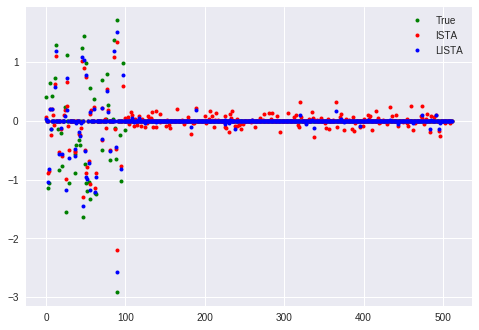

In [14]:
#print(b.shape)
#print(torch.from_numpy(b).float().size())
#print(x_est)
with torch.no_grad():
    b_torch=  torch.from_numpy(b).float()
    output_init = model(b_torch)
#print(output_init)
print(np.linalg.norm(output_init.detach().cpu().numpy()-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'r.', markersize=8, mec='red', label='ISTA')
plt.plot(np.arange(n),output_init.detach().cpu().numpy(), 'b.', markersize=8, mec='blue', label='LISTA')
#plt.plot(np.arange(n),output_init.detach().cpu().numpy(), 'bo', mfc = 'None', markersize=8, mec='blue', mew=1, label='LISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()